## Simulate non-isoplanatic imaging for LOW at 100MHz.

### The input data have been simulated in low-sims-mpc-10000m-prep

### Continuum Imaging and then ICAL are run to obtain an image and a set of components.

In [1]:
%matplotlib inline

import sys

from data_models.parameters import arl_path

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib import pylab as pylab

from data_models.memory_data_models import SkyModel
from data_models.polarisation import PolarisationFrame

from processing_library.util.coordinate_support import simulate_point, skycoord_to_lmn

from wrappers.serial.calibration.calibration_control import calibrate_function, create_calibration_controls
from wrappers.serial.skycomponent.operations import find_skycomponents, partition_skycomponent_neighbours

from wrappers.serial.visibility.base import create_blockvisibility, copy_visibility
from processing_library.image.operations import copy_image
from wrappers.serial.image.operations import show_image, qa_image
from wrappers.serial.simulation.testing_support import create_named_configuration, \
    create_low_test_skycomponents_from_gleam, create_unittest_components
from wrappers.serial.skycomponent.operations import filter_skycomponents_by_flux
from wrappers.serial.simulation.mpc import create_gaintable_from_screen, sum_visibility_over_partitions, \
    calculate_sf_from_screen
from wrappers.serial.skymodel.operations import show_skymodel

from processing_components.simulation.mpc import expand_skymodel_by_skycomponents

from wrappers.serial.imaging.primary_beams import create_low_test_beam
from wrappers.serial.skycomponent.operations import apply_beam_to_skycomponent
from wrappers.serial.imaging.base import create_image_from_visibility, advise_wide_field
from wrappers.serial.image.operations import import_image_from_fits, export_image_to_fits

from wrappers.arlexecute.visibility.coalesce import convert_blockvisibility_to_visibility
from wrappers.arlexecute.skycomponent.operations import insert_skycomponent
from wrappers.arlexecute.image.operations import smooth_image, show_components

from workflows.arlexecute.pipelines.pipeline_arlexecute import continuum_imaging_list_arlexecute_workflow, \
    ical_list_arlexecute_workflow
from workflows.serial.imaging.imaging_serial import invert_list_serial_workflow
from workflows.serial.imaging.imaging_serial import weight_list_serial_workflow, taper_list_serial_workflow
from workflows.serial.pipelines.pipeline_serial import continuum_imaging_list_serial_workflow, \
    ical_list_serial_workflow

from data_models.data_model_helpers import import_blockvisibility_from_hdf5

from wrappers.arlexecute.execution_support.arlexecute import arlexecute
from wrappers.arlexecute.execution_support.dask_init import get_dask_Client

In [2]:
import logging
def init_logging():
    logging.basicConfig(filename='results/low-sims-mpc.log',
                        filemode='a',
                        format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG)

init_logging()
log = logging.getLogger()
    
def lprint(*args):
    log.info(*args)
    print(*args)

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 14.0)
pylab.rcParams['image.cmap'] = 'rainbow'

In [4]:
n_workers=16
c = get_dask_Client(
    memory_limit=64 * 1024 * 1024 * 1024, n_workers=n_workers, threads_per_worker=1)
arlexecute.set_client(c)
# Initialise logging on the workers. This appears to only work using the process scheduler.
arlexecute.run(init_logging)

Creating LocalCluster and Dask Client
Diagnostic pages available on port http://127.0.0.1:8787


{'tcp://127.0.0.1:33115': None,
 'tcp://127.0.0.1:34427': None,
 'tcp://127.0.0.1:34467': None,
 'tcp://127.0.0.1:36121': None,
 'tcp://127.0.0.1:36575': None,
 'tcp://127.0.0.1:39521': None,
 'tcp://127.0.0.1:40147': None,
 'tcp://127.0.0.1:42281': None,
 'tcp://127.0.0.1:42609': None,
 'tcp://127.0.0.1:43361': None,
 'tcp://127.0.0.1:44503': None,
 'tcp://127.0.0.1:44833': None,
 'tcp://127.0.0.1:45375': None,
 'tcp://127.0.0.1:45457': None,
 'tcp://127.0.0.1:45565': None,
 'tcp://127.0.0.1:46849': None}

### Read the blockvis file from low-sims-mpc-10000-prep

In [6]:
rmax = 10000.0
blockvis = import_blockvisibility_from_hdf5('results/low-sims-mpc-skymodel-noniso-blockvis_rmax10000.0.hdf5')

In [7]:
nfreqwin = len(blockvis.frequency)
ntimes = len(blockvis.time)
frequency = blockvis.frequency
times = blockvis.time
phasecentre = blockvis.phasecentre

### Find sampling, image size, etc

In [8]:
Vobs = convert_blockvisibility_to_visibility(blockvis)
advice = advise_wide_field(Vobs, guard_band_image=2.0, delA=0.02)

cellsize = advice['cellsize']
vis_slices = advice['vis_slices']
npixel = advice['npixels2']

In [10]:
from workflows.arlexecute.imaging.imaging_arlexecute import invert_list_arlexecute_workflow
model = create_image_from_visibility(
    blockvis,
    npixel=npixel,
    frequency=frequency,
    nchan=nfreqwin,
    cellsize=cellsize,
    phasecentre=phasecentre)

vis_list = arlexecute.scatter([Vobs])
model_list = arlexecute.scatter([model])

In [11]:
cimg_list = continuum_imaging_list_arlexecute_workflow(
    vis_list,
    model_imagelist=model_list,
    context='timeslice',
    vis_slices=16,
    algorithm='msclean',
    scales=[0,3,10],
    niter=1000,
    fractional_threshold=0.5,
    threshold=0.5,
    nmajor=10,
    gain=0.1,
    psf_support=512,
    deconvolve_facets=8,
    deconvolve_overlap=32,
    deconvolve_taper='tukey')
    
cimg_deconvolved, cimg_residual, cimg_restored = arlexecute.compute(cimg_list, sync=True)

arlexecute.compute: Execution using Dask took 368.587 seconds


In [12]:
from processing_components.skycomponent.operations import find_skycomponents
recovered_cimg_components = find_skycomponents(cimg_restored[0], fwhm=2, threshold=0.35, npixels=12)
print(len(recovered_cimg_components))
print(recovered_cimg_components[0])

35
Skycomponent:
	Name: Segment 0
	Flux: [[0.4302912]]
	Frequency: [1.e+08]
	Direction: <SkyCoord (ICRS): (ra, dec) in deg
    (2.51035107, -43.65241974)>
	Shape: Point
	Params: {}
	Polarisation frame: stokesI



Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 4096, 4096)'
		max: '1.5853629211320006'
		min: '-0.331494970042775'
		rms: '0.056398736724982725'
		sum: '575.0630387469571'
		medianabs: '0.03706537919217928'
		median: '-0.0007393305678457682'



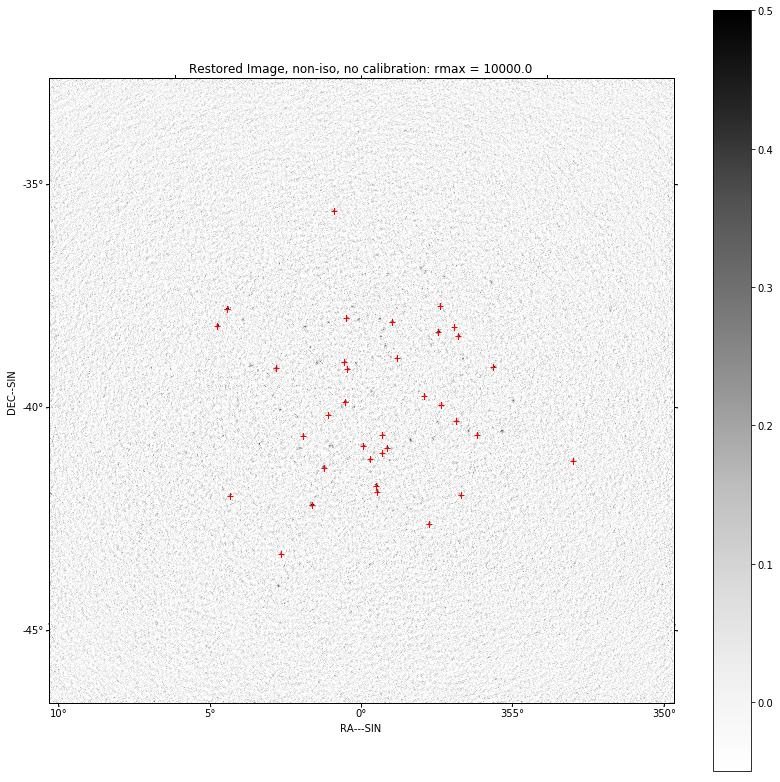

In [13]:
lprint(qa_image(cimg_restored[0]))
show_image(
    cimg_restored[0],
    cm='Greys',
    components=recovered_cimg_components,
    title='Restored Image, non-iso, no calibration: rmax = %.1f' % rmax,
    vmax=0.5, vmin=-0.05)

plt.savefig('figures/low-sims-mpc-noniso_cimg_restored_rmax%.1f.png' % rmax)
plt.show()

export_image_to_fits(cimg_deconvolved[0],
                     'results/low-sims-mpc-noniso-cimg-deconvolved_rmax%.1f.fits' % rmax)
export_image_to_fits(cimg_restored[0],
                     'results/low-sims-mpc-noniso-cimg-restored_rmax%.1f.fits' % rmax)
export_image_to_fits(cimg_residual[0][0],
                     'results/low-sims-mpc-noniso-cimg-residual_rmax%.1f.fits' % rmax)

In [14]:
ical_model = copy_image(cimg_deconvolved[0])
ical_model_list = arlexecute.scatter([ical_model])

In [15]:
controls = create_calibration_controls()

controls['T']['first_selfcal'] = 0
controls['T']['phase_only'] = True
controls['T']['timescale'] = 'auto'

ical_list = ical_list_arlexecute_workflow(
    vis_list,
    model_imagelist=ical_model_list,
    context='timeslice',
    vis_slices=16,
    algorithm='msclean',
    scales=[0,3,10],
    niter=1000,
    fractional_threshold=0.5,
    threshold=0.5,
    nmajor=10,
    gain=0.25,
    psf_support=512,
    deconvolve_facets=8,
    deconvolve_overlap=32,
    deconvolve_taper='tukey',
    timeslice='auto',
    global_solution=False,
    do_selfcal=True,
    calibration_context='T',
    controls=controls)
    
ical_deconvolved, ical_residual, ical_restored, gt_list = arlexecute.compute(ical_list, sync=True)

arlexecute.compute: Execution using Dask took 683.584 seconds


In [16]:
recovered_ical_components = find_skycomponents(ical_restored[0], fwhm=2, threshold=0.35, npixels=12)
print(len(recovered_ical_components))
print(recovered_ical_components[0])

20
Skycomponent:
	Name: Segment 0
	Flux: [[4.58843971]]
	Frequency: [1.e+08]
	Direction: <SkyCoord (ICRS): (ra, dec) in deg
    (1.50321991, -42.57639983)>
	Shape: Point
	Params: {}
	Polarisation frame: stokesI



In [17]:
from data_models.data_model_helpers import export_skycomponent_to_hdf5, export_gaintable_to_hdf5
export_skycomponent_to_hdf5(recovered_ical_components, 
                            'results/low-sims-mpc-noniso-ical-components_rmax%.1f.hdf5' % rmax)
export_image_to_fits(ical_deconvolved[0], 
                     'results/low-sims-mpc-noniso-ical-deconvolved_rmax%.1f.fits' % rmax)
export_gaintable_to_hdf5(gt_list[0]['T'], 
                         'results/low-sims-mpc-noniso-ical-gaintable_rmax%.1f.hdf5' % rmax)

Quality assessment:
	Origin: qa_image
	Context: 
	Data:
		shape: '(1, 1, 4096, 4096)'
		max: '4.588439705593004'
		min: '-0.2928786243389912'
		rms: '0.049056968404179176'
		sum: '747.7945922404211'
		medianabs: '0.03224520671697032'
		median: '-0.0005123707666847795'



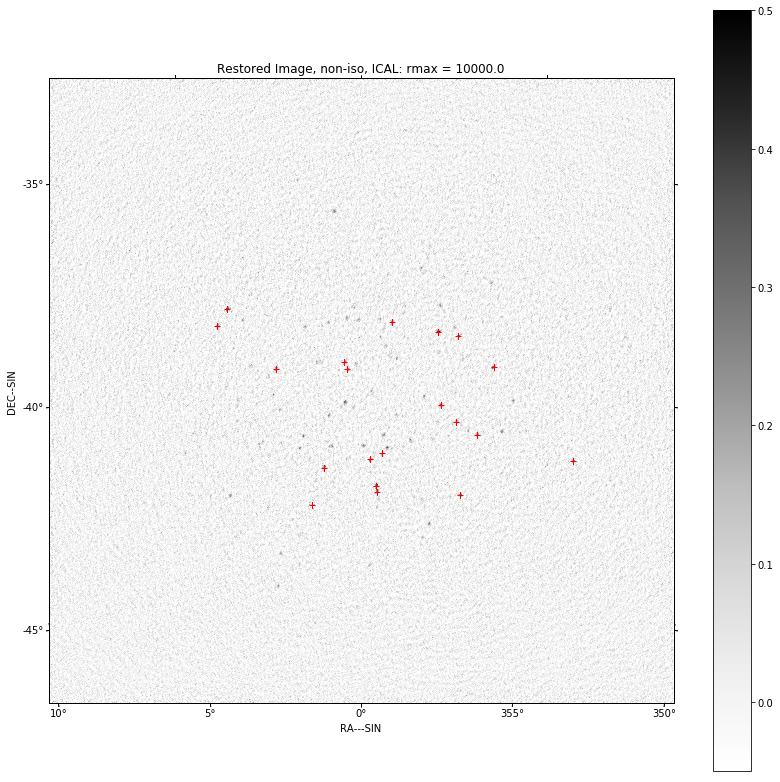

In [18]:
lprint(qa_image(ical_restored[0]))
show_image(
    ical_restored[0],
    components=recovered_ical_components,
    cm='Greys',
    title='Restored Image, non-iso, ICAL: rmax = %.1f' % rmax,
    vmax=0.5, vmin=-0.05)

plt.savefig('figures/low-sims-mpc-noniso_ical_restored_rmax%.1f.png' % rmax)
plt.show()

export_image_to_fits(ical_restored[0],
                     'results/low-sims-mpc-noniso-ical-restored_rmax%.1f.fits' % rmax)
export_image_to_fits(ical_residual[0][0],
                     'results/low-sims-mpc-noniso-ical-residual_rmax%.1f.fits' % rmax)



In [21]:
from data_models.data_model_helpers import import_skymodel_from_hdf5
gleam_skymodel_iso=import_skymodel_from_hdf5('results/low-sims-mpc-iso-skymodel_rmax%.1f.hdf5' % rmax)

In [22]:
from processing_components.skycomponent.operations import filter_skycomponents_by_flux
bright_gleam=filter_skycomponents_by_flux(gleam_skymodel_iso.components, flux_min=0.1)
def max_flux(elem):
    return numpy.max(elem.flux)
sorted_bright_gleam=sorted(bright_gleam, key=max_flux, reverse=True)

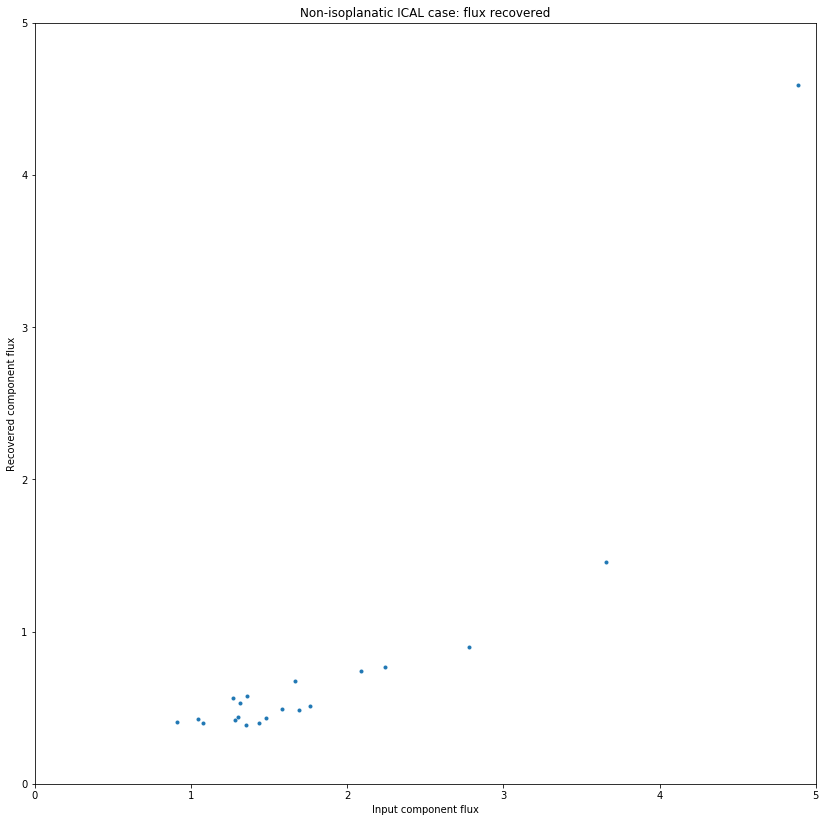

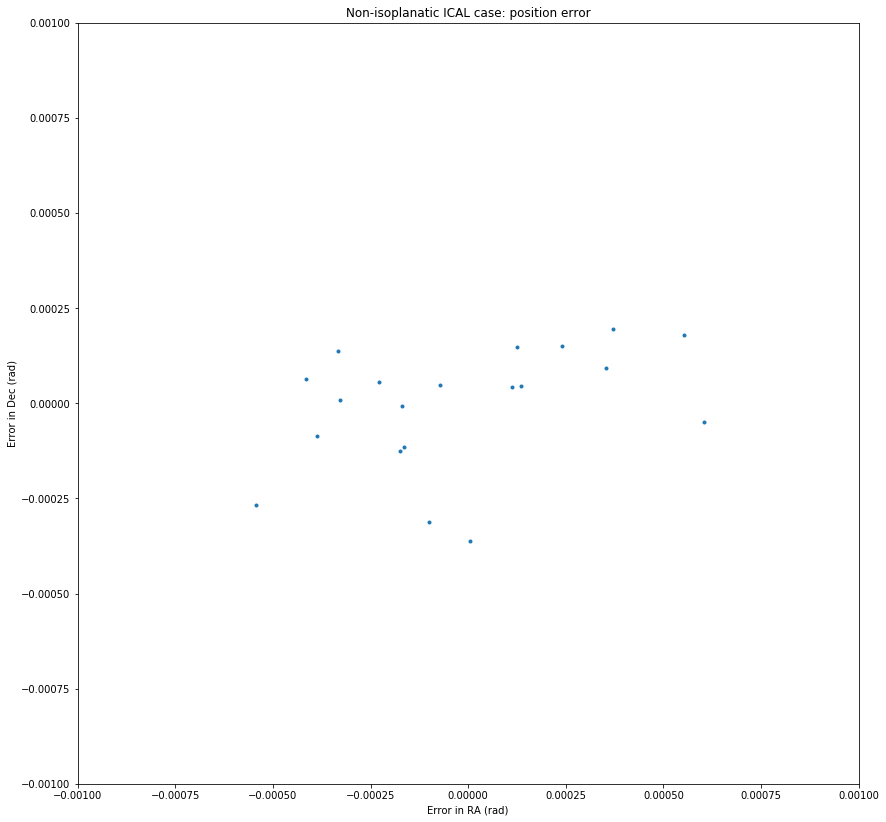

In [23]:
from wrappers.serial.skycomponent.operations import find_skycomponent_matches
matches = find_skycomponent_matches(recovered_ical_components, sorted_bright_gleam, tol=1e-3)
x=list()
y=list()
dx=list()
dy=list()
for match in matches:
    y.append(recovered_ical_components[match[0]].flux[0,0])
    x.append(sorted_bright_gleam[match[1]].flux[0,0])
    dx.append(recovered_ical_components[match[0]].direction.ra.rad-sorted_bright_gleam[match[1]].direction.ra.rad)
    dy.append(recovered_ical_components[match[0]].direction.dec.rad-sorted_bright_gleam[match[1]].direction.dec.rad)
        
plt.clf()
plt.plot(x, y, '.')
plt.xlim([0.0, 5.0])
plt.ylim([0.0, 5.0])
plt.xlabel('Input component flux')
plt.ylabel('Recovered component flux')
plt.title('Non-isoplanatic ICAL case: flux recovered')
plt.savefig('figures/ical_noniso_flux_errors%.1f.jpg' % rmax)
plt.show()
    
plt.clf()
plt.plot(dx, dy, '.')
plt.xlim([-1e-3, 1e-3])
plt.ylim([-1e-3, 1e-3])
plt.xlabel('Error in RA (rad)')
plt.ylabel('Error in Dec (rad)')
plt.title('Non-isoplanatic ICAL case: position error')
plt.savefig('figures/ical_noniso_position_errors%.1f.jpg' % rmax)
plt.show()
    



In [ ]:
arlexecute.close()